<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/GradCAM_ViT_Features_Single_Pass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download Image and Trained Model

In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# id = ['18A9mAt9r4CoXLeoCK2muPNvIEqVKvOaw']
id = ['1pZgspfWi1Mh8sqV_lbJLQTuFZyhnTPlA']
downloaded = drive.CreateFile({'id':id[0]}) 
downloaded.GetContentFile('localization_2.zip')
!unzip localization_2.zip

Archive:  localization_2.zip
  inflating: localization/001202.png  
  inflating: localization/001203.png  
  inflating: localization/1_frame132.png  
  inflating: localization/1_frame146.png  
  inflating: localization/16_frame119.png  
  inflating: localization/16_frame122.png  
  inflating: localization/5_frame078.png  
  inflating: localization/5_frame118.png  
  inflating: localization/combine_miccai18_ResNet50_256,320_170_best_checkpoint.pth.tar  
  inflating: localization/raw_image.png  


Fix seed to get result reproducibility

In [2]:
import random
import torch
import numpy as np
import os

def seed_everything(seed=42):
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

seed_everything()

Required Libs

In [3]:
! pip -q install timm

     |████████████████████████████████| 509 kB 7.0 MB/s 


# Vision Transformer

In [12]:
""" Vision Transformer (ViT) in PyTorch

A PyTorch implement of Vision Transformers as described in:

'An Image Is Worth 16 x 16 Words: Transformers for Image Recognition at Scale'
    - https://arxiv.org/abs/2010.11929

`How to train your ViT? Data, Augmentation, and Regularization in Vision Transformers`
    - https://arxiv.org/abs/2106.10270

The official jax code is released and available at https://github.com/google-research/vision_transformer

Acknowledgments:
* The paper authors for releasing code and weights, thanks!
* I fixed my class token impl based on Phil Wang's https://github.com/lucidrains/vit-pytorch ... check it out
for some einops/einsum fun
* Simple transformer style inspired by Andrej Karpathy's https://github.com/karpathy/minGPT
* Bert reference code checks against Huggingface Transformers and Tensorflow Bert

Hacked together by / Copyright 2020, Ross Wightman
"""
import math
import logging
from functools import partial
from collections import OrderedDict
from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint

from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD, IMAGENET_INCEPTION_MEAN, IMAGENET_INCEPTION_STD
from timm.models.helpers import build_model_with_cfg, resolve_pretrained_cfg, named_apply, adapt_input_conv, checkpoint_seq
from timm.models.layers import PatchEmbed, Mlp, DropPath, trunc_normal_, lecun_normal_
from timm.models.registry import register_model

_logger = logging.getLogger(__name__)


def _cfg(url='', **kwargs):
    return {
        'url': url,
        'num_classes': 1000, 'input_size': (3, 224, 224), 'pool_size': None,
        'crop_pct': .9, 'interpolation': 'bicubic', 'fixed_input_size': True,
        'mean': IMAGENET_INCEPTION_MEAN, 'std': IMAGENET_INCEPTION_STD,
        'first_conv': 'patch_embed.proj', 'classifier': 'head',
        **kwargs
    }


default_cfgs = {
    # patch models (weights from official Google JAX impl)
    'vit_tiny_patch16_224': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/'
            'Ti_16-i21k-300ep-lr_0.001-aug_none-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_224.npz'),
}


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        assert dim % num_heads == 0, 'dim should be divisible by num_heads'
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class LayerScale(nn.Module):
    def __init__(self, dim, init_values=1e-5, inplace=False):
        super().__init__()
        self.inplace = inplace
        self.gamma = nn.Parameter(init_values * torch.ones(dim))

    def forward(self, x):
        return x.mul_(self.gamma) if self.inplace else x * self.gamma


class Block(nn.Module):

    def __init__(
            self, dim, num_heads, mlp_ratio=4., qkv_bias=False, drop=0., attn_drop=0., init_values=None,
            drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        self.ls1 = LayerScale(dim, init_values=init_values) if init_values else nn.Identity()
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path1 = DropPath(drop_path) if drop_path > 0. else nn.Identity()

        self.norm2 = norm_layer(dim)
        self.mlp = Mlp(in_features=dim, hidden_features=int(dim * mlp_ratio), act_layer=act_layer, drop=drop)
        self.ls2 = LayerScale(dim, init_values=init_values) if init_values else nn.Identity()
        self.drop_path2 = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        x = x + self.drop_path1(self.ls1(self.attn(self.norm1(x))))
        x = x + self.drop_path2(self.ls2(self.mlp(self.norm2(x))))
        return x


class ResPostBlock(nn.Module):

    def __init__(
            self, dim, num_heads, mlp_ratio=4., qkv_bias=False, drop=0., attn_drop=0., init_values=None,
            drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.init_values = init_values

        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        self.norm1 = norm_layer(dim)
        self.drop_path1 = DropPath(drop_path) if drop_path > 0. else nn.Identity()

        self.mlp = Mlp(in_features=dim, hidden_features=int(dim * mlp_ratio), act_layer=act_layer, drop=drop)
        self.norm2 = norm_layer(dim)
        self.drop_path2 = DropPath(drop_path) if drop_path > 0. else nn.Identity()

        self.init_weights()

    def init_weights(self):
        # NOTE this init overrides that base model init with specific changes for the block type
        if self.init_values is not None:
            nn.init.constant_(self.norm1.weight, self.init_values)
            nn.init.constant_(self.norm2.weight, self.init_values)

    def forward(self, x):
        x = x + self.drop_path1(self.norm1(self.attn(x)))
        x = x + self.drop_path2(self.norm2(self.mlp(x)))
        return x


class ParallelBlock(nn.Module):

    def __init__(
            self, dim, num_heads, num_parallel=2, mlp_ratio=4., qkv_bias=False, init_values=None,
            drop=0., attn_drop=0., drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.num_parallel = num_parallel
        self.attns = nn.ModuleList()
        self.ffns = nn.ModuleList()
        for _ in range(num_parallel):
            self.attns.append(nn.Sequential(OrderedDict([
                ('norm', norm_layer(dim)),
                ('attn', Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)),
                ('ls', LayerScale(dim, init_values=init_values) if init_values else nn.Identity()),
                ('drop_path', DropPath(drop_path) if drop_path > 0. else nn.Identity())
            ])))
            self.ffns.append(nn.Sequential(OrderedDict([
                ('norm', norm_layer(dim)),
                ('mlp', Mlp(dim, hidden_features=int(dim * mlp_ratio), act_layer=act_layer, drop=drop)),
                ('ls', LayerScale(dim, init_values=init_values) if init_values else nn.Identity()),
                ('drop_path', DropPath(drop_path) if drop_path > 0. else nn.Identity())
            ])))

    def _forward_jit(self, x):
        x = x + torch.stack([attn(x) for attn in self.attns]).sum(dim=0)
        x = x + torch.stack([ffn(x) for ffn in self.ffns]).sum(dim=0)
        return x

    @torch.jit.ignore
    def _forward(self, x):
        x = x + sum(attn(x) for attn in self.attns)
        x = x + sum(ffn(x) for ffn in self.ffns)
        return x

    def forward(self, x):
        if torch.jit.is_scripting() or torch.jit.is_tracing():
            return self._forward_jit(x)
        else:
            return self._forward(x)


class VisionTransformer(nn.Module):
    """ Vision Transformer

    A PyTorch impl of : `An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale`
        - https://arxiv.org/abs/2010.11929
    """

    def __init__(
            self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, global_pool='token',
            embed_dim=768, depth=12, num_heads=12, mlp_ratio=4., qkv_bias=True, init_values=None,
            class_token=True, no_embed_class=False, fc_norm=None, drop_rate=0., attn_drop_rate=0., drop_path_rate=0.,
            weight_init='', embed_layer=PatchEmbed, norm_layer=None, act_layer=None, block_fn=Block):
        """
        Args:
            img_size (int, tuple): input image size
            patch_size (int, tuple): patch size
            in_chans (int): number of input channels
            num_classes (int): number of classes for classification head
            global_pool (str): type of global pooling for final sequence (default: 'token')
            embed_dim (int): embedding dimension
            depth (int): depth of transformer
            num_heads (int): number of attention heads
            mlp_ratio (int): ratio of mlp hidden dim to embedding dim
            qkv_bias (bool): enable bias for qkv if True
            init_values: (float): layer-scale init values
            class_token (bool): use class token
            fc_norm (Optional[bool]): pre-fc norm after pool, set if global_pool == 'avg' if None (default: None)
            drop_rate (float): dropout rate
            attn_drop_rate (float): attention dropout rate
            drop_path_rate (float): stochastic depth rate
            weight_init (str): weight init scheme
            embed_layer (nn.Module): patch embedding layer
            norm_layer: (nn.Module): normalization layer
            act_layer: (nn.Module): MLP activation layer
        """
        super().__init__()
        assert global_pool in ('', 'avg', 'token')
        assert class_token or global_pool != 'token'
        use_fc_norm = global_pool == 'avg' if fc_norm is None else fc_norm
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)
        act_layer = act_layer or nn.GELU

        self.num_classes = num_classes
        self.global_pool = global_pool
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.num_prefix_tokens = 1 if class_token else 0
        self.no_embed_class = no_embed_class
        self.grad_checkpointing = False

        self.patch_embed = embed_layer(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim)) if class_token else None
        embed_len = num_patches if no_embed_class else num_patches + self.num_prefix_tokens
        self.pos_embed = nn.Parameter(torch.randn(1, embed_len, embed_dim) * .02)
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.Sequential(*[
            block_fn(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, init_values=init_values,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer, act_layer=act_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim) if not use_fc_norm else nn.Identity()

        # Classifier Head
        self.fc_norm = norm_layer(embed_dim) if use_fc_norm else nn.Identity()
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        if weight_init != 'skip':
            self.init_weights(weight_init)

    def init_weights(self, mode=''):
        assert mode in ('jax', 'jax_nlhb', 'moco', '')
        head_bias = -math.log(self.num_classes) if 'nlhb' in mode else 0.
        trunc_normal_(self.pos_embed, std=.02)
        if self.cls_token is not None:
            nn.init.normal_(self.cls_token, std=1e-6)
        named_apply(get_init_weights_vit(mode, head_bias), self)

    def _init_weights(self, m):
        # this fn left here for compat with downstream users
        init_weights_vit_timm(m)

    @torch.jit.ignore()
    def load_pretrained(self, checkpoint_path, prefix=''):
        _load_weights(self, checkpoint_path, prefix)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token', 'dist_token'}

    @torch.jit.ignore
    def group_matcher(self, coarse=False):
        return dict(
            stem=r'^cls_token|pos_embed|patch_embed',  # stem and embed
            blocks=[(r'^blocks\.(\d+)', None), (r'^norm', (99999,))]
        )

    @torch.jit.ignore
    def set_grad_checkpointing(self, enable=True):
        self.grad_checkpointing = enable

    @torch.jit.ignore
    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes: int, global_pool=None):
        self.num_classes = num_classes
        if global_pool is not None:
            assert global_pool in ('', 'avg', 'token')
            self.global_pool = global_pool
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def _pos_embed(self, x):
        if self.no_embed_class:
            # deit-3, updated JAX (big vision)
            # position embedding does not overlap with class token, add then concat
            x = x + self.pos_embed
            if self.cls_token is not None:
                x = torch.cat((self.cls_token.expand(x.shape[0], -1, -1), x), dim=1)
        else:
            # original timm, JAX, and deit vit impl
            # pos_embed has entry for class token, concat then add
            if self.cls_token is not None:
                x = torch.cat((self.cls_token.expand(x.shape[0], -1, -1), x), dim=1)
            x = x + self.pos_embed
        return self.pos_drop(x)

    def forward_features(self, x):
        x = self.patch_embed(x)
        x = self._pos_embed(x)
        if self.grad_checkpointing and not torch.jit.is_scripting():
            x = checkpoint_seq(self.blocks, x)
        else:
            x = self.blocks(x)
        x = self.norm(x)
        return x

    def forward_head(self, x, pre_logits: bool = False):
        if self.global_pool:
            x = x[:, self.num_prefix_tokens:].mean(dim=1) if self.global_pool == 'avg' else x[:, 0]
        x = self.fc_norm(x)
        return x if pre_logits else self.head(x)

    def forward(self, x):
        x = self.forward_features(x)
        x_feat = x.clone()
        x = self.forward_head(x)
        return x, x_feat


def init_weights_vit_timm(module: nn.Module, name: str = ''):
    """ ViT weight initialization, original timm impl (for reproducibility) """
    if isinstance(module, nn.Linear):
        trunc_normal_(module.weight, std=.02)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif hasattr(module, 'init_weights'):
        module.init_weights()


def init_weights_vit_jax(module: nn.Module, name: str = '', head_bias: float = 0.):
    """ ViT weight initialization, matching JAX (Flax) impl """
    if isinstance(module, nn.Linear):
        if name.startswith('head'):
            nn.init.zeros_(module.weight)
            nn.init.constant_(module.bias, head_bias)
        else:
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.normal_(module.bias, std=1e-6) if 'mlp' in name else nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Conv2d):
        lecun_normal_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif hasattr(module, 'init_weights'):
        module.init_weights()


def init_weights_vit_moco(module: nn.Module, name: str = ''):
    """ ViT weight initialization, matching moco-v3 impl minus fixed PatchEmbed """
    if isinstance(module, nn.Linear):
        if 'qkv' in name:
            # treat the weights of Q, K, V separately
            val = math.sqrt(6. / float(module.weight.shape[0] // 3 + module.weight.shape[1]))
            nn.init.uniform_(module.weight, -val, val)
        else:
            nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif hasattr(module, 'init_weights'):
        module.init_weights()


def get_init_weights_vit(mode='jax', head_bias: float = 0.):
    if 'jax' in mode:
        return partial(init_weights_vit_jax, head_bias=head_bias)
    elif 'moco' in mode:
        return init_weights_vit_moco
    else:
        return init_weights_vit_timm


@torch.no_grad()
def _load_weights(model: VisionTransformer, checkpoint_path: str, prefix: str = ''):
    """ Load weights from .npz checkpoints for official Google Brain Flax implementation
    """
    import numpy as np

    def _n2p(w, t=True):
        if w.ndim == 4 and w.shape[0] == w.shape[1] == w.shape[2] == 1:
            w = w.flatten()
        if t:
            if w.ndim == 4:
                w = w.transpose([3, 2, 0, 1])
            elif w.ndim == 3:
                w = w.transpose([2, 0, 1])
            elif w.ndim == 2:
                w = w.transpose([1, 0])
        return torch.from_numpy(w)

    w = np.load(checkpoint_path)
    if not prefix and 'opt/target/embedding/kernel' in w:
        prefix = 'opt/target/'

    if hasattr(model.patch_embed, 'backbone'):
        # hybrid
        backbone = model.patch_embed.backbone
        stem_only = not hasattr(backbone, 'stem')
        stem = backbone if stem_only else backbone.stem
        stem.conv.weight.copy_(adapt_input_conv(stem.conv.weight.shape[1], _n2p(w[f'{prefix}conv_root/kernel'])))
        stem.norm.weight.copy_(_n2p(w[f'{prefix}gn_root/scale']))
        stem.norm.bias.copy_(_n2p(w[f'{prefix}gn_root/bias']))
        if not stem_only:
            for i, stage in enumerate(backbone.stages):
                for j, block in enumerate(stage.blocks):
                    bp = f'{prefix}block{i + 1}/unit{j + 1}/'
                    for r in range(3):
                        getattr(block, f'conv{r + 1}').weight.copy_(_n2p(w[f'{bp}conv{r + 1}/kernel']))
                        getattr(block, f'norm{r + 1}').weight.copy_(_n2p(w[f'{bp}gn{r + 1}/scale']))
                        getattr(block, f'norm{r + 1}').bias.copy_(_n2p(w[f'{bp}gn{r + 1}/bias']))
                    if block.downsample is not None:
                        block.downsample.conv.weight.copy_(_n2p(w[f'{bp}conv_proj/kernel']))
                        block.downsample.norm.weight.copy_(_n2p(w[f'{bp}gn_proj/scale']))
                        block.downsample.norm.bias.copy_(_n2p(w[f'{bp}gn_proj/bias']))
        embed_conv_w = _n2p(w[f'{prefix}embedding/kernel'])
    else:
        embed_conv_w = adapt_input_conv(
            model.patch_embed.proj.weight.shape[1], _n2p(w[f'{prefix}embedding/kernel']))
    model.patch_embed.proj.weight.copy_(embed_conv_w)
    model.patch_embed.proj.bias.copy_(_n2p(w[f'{prefix}embedding/bias']))
    model.cls_token.copy_(_n2p(w[f'{prefix}cls'], t=False))
    pos_embed_w = _n2p(w[f'{prefix}Transformer/posembed_input/pos_embedding'], t=False)
    if pos_embed_w.shape != model.pos_embed.shape:
        pos_embed_w = resize_pos_embed(  # resize pos embedding when different size from pretrained weights
            pos_embed_w,
            model.pos_embed,
            getattr(model, 'num_prefix_tokens', 1),
            model.patch_embed.grid_size
        )
    model.pos_embed.copy_(pos_embed_w)
    model.norm.weight.copy_(_n2p(w[f'{prefix}Transformer/encoder_norm/scale']))
    model.norm.bias.copy_(_n2p(w[f'{prefix}Transformer/encoder_norm/bias']))
    if isinstance(model.head, nn.Linear) and model.head.bias.shape[0] == w[f'{prefix}head/bias'].shape[-1]:
        model.head.weight.copy_(_n2p(w[f'{prefix}head/kernel']))
        model.head.bias.copy_(_n2p(w[f'{prefix}head/bias']))
    # NOTE representation layer has been removed, not used in latest 21k/1k pretrained weights
    # if isinstance(getattr(model.pre_logits, 'fc', None), nn.Linear) and f'{prefix}pre_logits/bias' in w:
    #     model.pre_logits.fc.weight.copy_(_n2p(w[f'{prefix}pre_logits/kernel']))
    #     model.pre_logits.fc.bias.copy_(_n2p(w[f'{prefix}pre_logits/bias']))
    for i, block in enumerate(model.blocks.children()):
        block_prefix = f'{prefix}Transformer/encoderblock_{i}/'
        mha_prefix = block_prefix + 'MultiHeadDotProductAttention_1/'
        block.norm1.weight.copy_(_n2p(w[f'{block_prefix}LayerNorm_0/scale']))
        block.norm1.bias.copy_(_n2p(w[f'{block_prefix}LayerNorm_0/bias']))
        block.attn.qkv.weight.copy_(torch.cat([
            _n2p(w[f'{mha_prefix}{n}/kernel'], t=False).flatten(1).T for n in ('query', 'key', 'value')]))
        block.attn.qkv.bias.copy_(torch.cat([
            _n2p(w[f'{mha_prefix}{n}/bias'], t=False).reshape(-1) for n in ('query', 'key', 'value')]))
        block.attn.proj.weight.copy_(_n2p(w[f'{mha_prefix}out/kernel']).flatten(1))
        block.attn.proj.bias.copy_(_n2p(w[f'{mha_prefix}out/bias']))
        for r in range(2):
            getattr(block.mlp, f'fc{r + 1}').weight.copy_(_n2p(w[f'{block_prefix}MlpBlock_3/Dense_{r}/kernel']))
            getattr(block.mlp, f'fc{r + 1}').bias.copy_(_n2p(w[f'{block_prefix}MlpBlock_3/Dense_{r}/bias']))
        block.norm2.weight.copy_(_n2p(w[f'{block_prefix}LayerNorm_2/scale']))
        block.norm2.bias.copy_(_n2p(w[f'{block_prefix}LayerNorm_2/bias']))


def resize_pos_embed(posemb, posemb_new, num_prefix_tokens=1, gs_new=()):
    # Rescale the grid of position embeddings when loading from state_dict. Adapted from
    # https://github.com/google-research/vision_transformer/blob/00883dd691c63a6830751563748663526e811cee/vit_jax/checkpoint.py#L224
    _logger.info('Resized position embedding: %s to %s', posemb.shape, posemb_new.shape)
    ntok_new = posemb_new.shape[1]
    if num_prefix_tokens:
        posemb_prefix, posemb_grid = posemb[:, :num_prefix_tokens], posemb[0, num_prefix_tokens:]
        ntok_new -= num_prefix_tokens
    else:
        posemb_prefix, posemb_grid = posemb[:, :0], posemb[0]
    gs_old = int(math.sqrt(len(posemb_grid)))
    if not len(gs_new):  # backwards compatibility
        gs_new = [int(math.sqrt(ntok_new))] * 2
    assert len(gs_new) >= 2
    _logger.info('Position embedding grid-size from %s to %s', [gs_old, gs_old], gs_new)
    posemb_grid = posemb_grid.reshape(1, gs_old, gs_old, -1).permute(0, 3, 1, 2)
    posemb_grid = F.interpolate(posemb_grid, size=gs_new, mode='bicubic', align_corners=False)
    posemb_grid = posemb_grid.permute(0, 2, 3, 1).reshape(1, gs_new[0] * gs_new[1], -1)
    posemb = torch.cat([posemb_prefix, posemb_grid], dim=1)
    return posemb


def checkpoint_filter_fn(state_dict, model, adapt_layer_scale=False):
    """ convert patch embedding weight from manual patchify + linear proj to conv"""
    import re
    out_dict = {}
    if 'model' in state_dict:
        # For deit models
        state_dict = state_dict['model']

    for k, v in state_dict.items():
        if 'patch_embed.proj.weight' in k and len(v.shape) < 4:
            # For old models that I trained prior to conv based patchification
            O, I, H, W = model.patch_embed.proj.weight.shape
            v = v.reshape(O, -1, H, W)
        elif k == 'pos_embed' and v.shape[1] != model.pos_embed.shape[1]:
            # To resize pos embedding when using model at different size from pretrained weights
            v = resize_pos_embed(
                v,
                model.pos_embed,
                0 if getattr(model, 'no_embed_class') else getattr(model, 'num_prefix_tokens', 1),
                model.patch_embed.grid_size
            )
        elif adapt_layer_scale and 'gamma_' in k:
            # remap layer-scale gamma into sub-module (deit3 models)
            k = re.sub(r'gamma_([0-9])', r'ls\1.gamma', k)
        elif 'pre_logits' in k:
            # NOTE representation layer removed as not used in latest 21k/1k pretrained weights
            continue
        out_dict[k] = v
    return out_dict


def _create_vision_transformer(variant, pretrained=False, **kwargs):
    if kwargs.get('features_only', None):
        raise RuntimeError('features_only not implemented for Vision Transformer models.')

    pretrained_cfg = resolve_pretrained_cfg(variant, pretrained_cfg=kwargs.pop('pretrained_cfg', None))
    model = build_model_with_cfg(
        VisionTransformer, variant, pretrained,
        pretrained_cfg=pretrained_cfg,
        pretrained_filter_fn=checkpoint_filter_fn,
        pretrained_custom_load='npz' in pretrained_cfg['url'],
        **kwargs)
    return model


@register_model
def vit_tiny_patch16_224(pretrained=False, **kwargs):
    """ ViT-Tiny (Vit-Ti/16)
    """
    model_kwargs = dict(patch_size=16, embed_dim=192, depth=12, num_heads=3, **kwargs)
    model = _create_vision_transformer('vit_tiny_patch16_224', pretrained=pretrained, **model_kwargs)
    return model

# Single Pass GradCAM-ViT

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


feature_map: torch.Size([1, 197, 192])
feature_map v2: torch.Size([1, 192, 14, 14])
feature_map_pooled: (14, 14)
Probability: [0.225, 0.979, 0.011, 0.993, 0.617, 0.413, 0.172, 0.372, 0.166, 0.583, 0.429]
Labels: [0, 3, 5, 10] Predictions: [1, 3, 4, 9]
pooled_gradients torch.Size([192])
activation torch.Size([1, 192, 14, 14])
min max tensor(0.) tensor(1.) shape: torch.Size([14, 14])
hmap (14, 14) feature_map_pooled (14, 14) 0.36039698 0.020997345
feature_map_class: (8,)
feature_map_class_final: torch.Size([1, 512])
pooled_gradients torch.Size([192])
activation torch.Size([1, 192, 14, 14])
min max tensor(0.) tensor(1.) shape: torch.Size([14, 14])
hmap (14, 14) feature_map_pooled (14, 14) 0.36039698 0.020997345
feature_map_class: (7,)
feature_map_class_final: torch.Size([1, 512])
pooled_gradients torch.Size([192])
activation torch.Size([1, 192, 14, 14])
min max tensor(0.) tensor(1.) shape: torch.Size([14, 14])
hmap (14, 14) feature_map_pooled (14, 14) 0.36039698 0.020997345
feature_map_cl

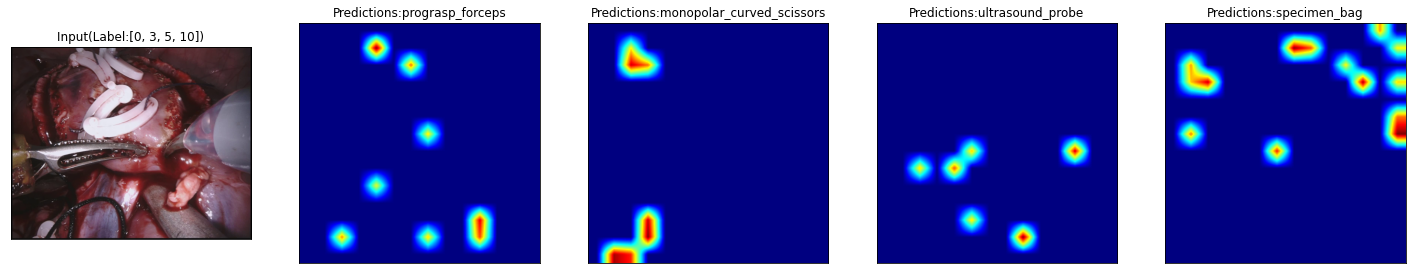

In [13]:
import torch
import torch.nn as nn
from torch.nn import DataParallel
import torch.nn.functional as F
from torchvision import transforms as tf
from PIL import Image
import matplotlib.pyplot as plt
import cv2
#from torchvision import models

def reg_hook_gradcam():
    # gradients for gradcam are stored here
    stored_grads = torch.Tensor([])
    stored_fpass = torch.Tensor([])

    def bpass_hook(self, gin, gout):
        global stored_grads
        stored_grads = gout

    def fpass_hook(self, ten_in, ten_out):
        global stored_fpass
        stored_fpass = ten_out

    # register hooks for gradCAM model.layer4[-1].conv1
    #last_conv_layer = model.model.features.denseblock4.denselayer16.conv2
    #last_conv_layer = model.layer4[2].conv3 #resnet
    #last_conv_layer = model.layer4[-1].conv1
    last_conv_layer = model.blocks[-1].norm1
    handle_b = last_conv_layer.register_backward_hook(bpass_hook)
    handle_f = last_conv_layer.register_forward_hook(fpass_hook)

def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))
    # Bring the channels to the first dimension like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result


def get_gradcam(model, img, lab):
    reg_hook_gradcam()
    out, feature_map = model(img)
    out, feature_map = out.cpu(), feature_map.cpu()
    print('feature_map:',feature_map.shape)
    feature_map = reshape_transform(feature_map)
    print('feature_map v2:',feature_map.shape)
    feature_map_pooled = F.adaptive_avg_pool3d(feature_map, [1,14,14]).squeeze().detach().numpy()
    print('feature_map_pooled:',feature_map_pooled.shape)
    out = torch.sigmoid(out)
    true_labels = np.argwhere(lab.cpu()==1)[1]
    pred_labels = np.argwhere(out.cpu()>0.5)[1]
    print('Probability:',[round(pro.item(), 3) for pro in out.squeeze()])
    print('Labels:',[tl.item() for tl in true_labels],'Predictions:', [pl.item() for pl in pred_labels])
    pred_lab_each = []
    for ii in pred_labels:
        backward_arg = torch.zeros(1,11)
        backward_arg[0,ii] = 1
        pred_lab_each.append(backward_arg)

    #a = pred_lab_each[0]
    img_hmap = np.transpose(img.squeeze().cpu().numpy(),(1,2,0))
    supim_all = []
    heatmap_all = []
    feature_maps_all = []
    for a in pred_lab_each:
        out.backward(a, retain_graph=True)
        gradients = stored_grads[0].clone()
        activations = stored_fpass[0].clone().unsqueeze(0)
        activations = activations.detach()

        gradients = reshape_transform(gradients)
        activations = reshape_transform(activations)

        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
        print('pooled_gradients', pooled_gradients.shape)
        for j in range(gradients.shape[1]):
            activations[:, j, :, :] *= pooled_gradients[j]

        print('activation', activations.shape)
        heatmap = torch.sum(activations, dim=1).squeeze().cpu()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= torch.max(heatmap)
        print('min max', heatmap.min(), heatmap.max(), 'shape:', heatmap.shape)

        hmap = heatmap.numpy()
        hmap[hmap<0.60] = 0
        print('hmap',hmap.shape, 'feature_map_pooled',feature_map_pooled.shape, feature_map_pooled.max(), feature_map_pooled.min())
        feature_map_class = feature_map_pooled[hmap>0] #then pooling to 512
        print('feature_map_class:',feature_map_class.shape)
        feature_map_class_final = F.adaptive_avg_pool1d(torch.tensor(feature_map_class[None]),[512])
        print('feature_map_class_final:',feature_map_class_final.shape)
        feature_map_2d = feature_map_pooled.copy()
        feature_map_2d[hmap==0] = 0
        feature_map_2d_resized = cv2.resize(feature_map_2d, (img_hmap.shape[1], img_hmap.shape[0]))
        feature_maps_all.append(feature_map_2d_resized)

        heatmap1 = cv2.resize(hmap, (img_hmap.shape[1], img_hmap.shape[0]))
        heatmap1 = np.uint8(-255 * heatmap1 + 255)
        heatmap1 = cv2.applyColorMap(heatmap1, cv2.COLORMAP_JET)
        heatmap_all.append(heatmap1)
    return heatmap_all, pred_labels, true_labels, feature_maps_all, feature_map_class_final

model = vit_tiny_patch16_224(pretrained=True)
model.head = nn.Linear(model.head.in_features, 11)
model.cuda();
model.eval();

image_name = "localization/1_frame146.png"   
classes = ['bipolar_forceps', 'prograsp_forceps', 'large_needle_driver', 'monopolar_curved_scissors', 'ultrasound_probe', 'suction', 'clip_applier', 'stapler', 'hook', 'specimen_bag', 'tissue']

'''------------------------------------- Load image ------------------------------------'''
image = Image.open(image_name).convert('RGB')
transforms = tf.Compose([tf.Resize((224,224)), 
                        tf.ToTensor(),
                        tf.Normalize([0.4084945, 0.25513682, 0.25353566], [0.22662906, 0.20201652, 0.1962526 ])])

img = transforms(image).cuda()
lab = torch.tensor([1,0,0,1,0,1,0,0,0,0,1])
img, lab = img[None], lab[None]
heatmap_all, pred_labels, true_labels, feature_maps_all, feature_map_class_final = get_gradcam(model, img, lab)

num_img = len(heatmap_all)+1
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
#ax[0].imshow(img[0].detach().permute(1,2,0).cpu())
ax[0].imshow(image)
ax[0].set_title('Input(Label:{})'.format([tl.item() for tl in true_labels]))

for idx, heatmap in enumerate(heatmap_all):
    ax[idx+1].imshow(heatmap)
    ax[idx+1].set_title('Predictions:{}'.format([classes[pl.item()] for pl in pred_labels][idx]))